In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [3]:
import itertools
from sklearn.model_selection import KFold

In [4]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes
from decoders import lr_decode_windowed

In [5]:
start_times = {'indy_20160426_01': 0,
               'indy_20160622_01':1700,
               'indy_20160624_03': 500,
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161011_03': 0,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }


### Initial windowing

In [6]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df1 = pickle.load(f)
with open('/home/akumar/nse/neural_control/data/sabes_decoding_sf.dat', 'rb') as f:
    sabes_df2 = pickle.load(f)

In [9]:
sabes_df2.iloc[0]['dimreduc_args']

{'T': 3, 'loss_type': 'trace', 'n_init': 10}

In [8]:
sabes_df2 = pd.DataFrame(sabes_df2)

In [6]:
# Approach (1): Calculate decoder on segmented version of the time series
# Approach (2): Use whole series decoder and measure its performance on different segmentations of the time series

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2'],
      dtype='object')

In [1]:
# Looking at Approach 2

In [15]:
sabes_df.iloc[2000]['decoder_args']

{'trainlag': 4, 'testlag': 4, 'decoding_window': 5}

In [32]:
dimvals

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [94]:
data_files = np.unique(sabes_df1['data_file'].values)
folds = np.arange(5)
#dimvals = np.unique(sabes_df1['dim'].values)[0:21]
dimvals = np.array([2, 6, 10, 15, 20])

# Pick one
windows = [(0, 20), (-10, 10), (-5, 5), (0, 10), (0, 30), (-20, 20), (-20, 0), (20, 30), (10, 20)]
lag = 4

wr2 = np.zeros((len(data_files), folds.size, dimvals.size, len(windows), 2, 6))

for i, data_file in enumerate(data_files):
    
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    for f, fold in enumerate(folds):
        for d, dimval in tqdm(enumerate(dimvals)):

            df1 = apply_df_filters(sabes_df1, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dimval)
            df2 = apply_df_filters(sabes_df2, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval,
                                    dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

            assert(df1.shape[0] == 1)
            assert(df2.shape[0] == 1)

            assert(np.all(df1.iloc[0]['train_idxs'] == df2.iloc[0]['train_idxs']))
            assert(np.all(df1.iloc[0]['test_idxs'] == df2.iloc[0]['test_idxs']))

            xpca = X @ df1.iloc[0]['coef'][:, 0:dimval]
            xfcca = X @ df2.iloc[0]['coef']

            # Apply projection
            for j, window in enumerate(windows):
                r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _ = lr_decode_windowed(xpca, Z, lag, window, dat['transition_times'],
                                                            df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=5) 
                wr2[i, f, d, j, 0, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
                r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _ = lr_decode_windowed(xfcca, Z, lag, window, dat['transition_times'],
                                                            df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=5)
                wr2[i, f, d, j, 1, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.39s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [02:38, 31.66s/it]
5it [02:51, 34.34s/it]
5it [02:46, 33.30s/it]
5it [02:42, 32.41s/it]
5it [02:38, 31.70s/it]


Processing spikes


100%|██████████| 1/1 [00:19<00:00, 19.93s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [04:33, 54.61s/it]
5it [04:40, 56.15s/it]
5it [04:38, 55.69s/it]
5it [04:27, 53.46s/it]
5it [04:18, 51.69s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:20,  4.10s/it]
5it [00:21,  4.31s/it]
5it [00:21,  4.26s/it]
5it [00:20,  4.14s/it]
5it [00:20,  4.09s/it]


Processing spikes


100%|██████████| 1/1 [00:27<00:00, 27.59s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [14:27, 173.49s/it]
5it [15:19, 183.91s/it]
5it [15:01, 180.23s/it]
5it [14:27, 173.43s/it]
5it [14:17, 171.41s/it]


Processing spikes


100%|██████████| 1/1 [00:11<00:00, 11.98s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [02:45, 33.14s/it]
5it [02:55, 35.15s/it]
5it [02:53, 34.72s/it]
5it [02:49, 33.93s/it]
5it [02:46, 33.39s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:13,  2.67s/it]
5it [00:14,  2.86s/it]
5it [00:13,  2.78s/it]
5it [00:13,  2.75s/it]
5it [00:13,  2.67s/it]


Processing spikes


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:12,  2.48s/it]
5it [00:13,  2.68s/it]
5it [00:13,  2.63s/it]
5it [00:12,  2.57s/it]
5it [00:12,  2.48s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:17,  3.51s/it]
5it [00:19,  3.80s/it]
5it [00:18,  3.70s/it]
5it [00:18,  3.60s/it]
5it [00:17,  3.52s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.26s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:14,  2.81s/it]
5it [00:14,  2.99s/it]
5it [00:14,  2.93s/it]
5it [00:14,  2.87s/it]
5it [00:14,  2.82s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.09s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:12,  2.57s/it]
5it [00:13,  2.79s/it]
5it [00:13,  2.72s/it]
5it [00:13,  2.66s/it]
5it [00:12,  2.57s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.13s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:20,  4.11s/it]
5it [00:21,  4.30s/it]
5it [00:21,  4.25s/it]
5it [00:20,  4.15s/it]
5it [00:20,  4.02s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:18,  3.71s/it]
5it [00:19,  3.91s/it]
5it [00:18,  3.79s/it]
5it [00:18,  3.72s/it]
5it [00:18,  3.65s/it]


Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.51s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:30,  6.16s/it]
5it [00:32,  6.41s/it]
5it [00:31,  6.37s/it]
5it [00:31,  6.22s/it]
5it [00:30,  6.08s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.26s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:23,  4.68s/it]
5it [00:24,  4.94s/it]
5it [00:24,  4.89s/it]
5it [00:24,  4.85s/it]
5it [00:23,  4.67s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.20s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:23,  4.74s/it]
5it [00:25,  5.11s/it]
5it [00:25,  5.03s/it]
5it [00:24,  4.85s/it]
5it [00:23,  4.73s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.00s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:22,  4.50s/it]
5it [00:23,  4.80s/it]
5it [00:23,  4.72s/it]
5it [00:23,  4.63s/it]
5it [00:22,  4.48s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:21,  4.27s/it]
5it [00:22,  4.55s/it]
5it [00:22,  4.46s/it]
5it [00:22,  4.40s/it]
5it [00:21,  4.29s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.16s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:23,  4.65s/it]
5it [00:24,  4.97s/it]
5it [00:24,  4.83s/it]
5it [00:23,  4.75s/it]
5it [00:23,  4.68s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:22,  4.52s/it]
5it [00:24,  4.82s/it]
5it [00:23,  4.72s/it]
5it [00:23,  4.62s/it]
5it [00:22,  4.54s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:26,  5.34s/it]
5it [00:27,  5.56s/it]
5it [00:27,  5.53s/it]
5it [00:26,  5.36s/it]
5it [00:26,  5.22s/it]


Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.97s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
0it [00:00, ?it/s]


ValueError: need at least one array to concatenate

In [39]:
np.savez('windowed_r2.npy', wr2)

In [40]:
len(windows)

7

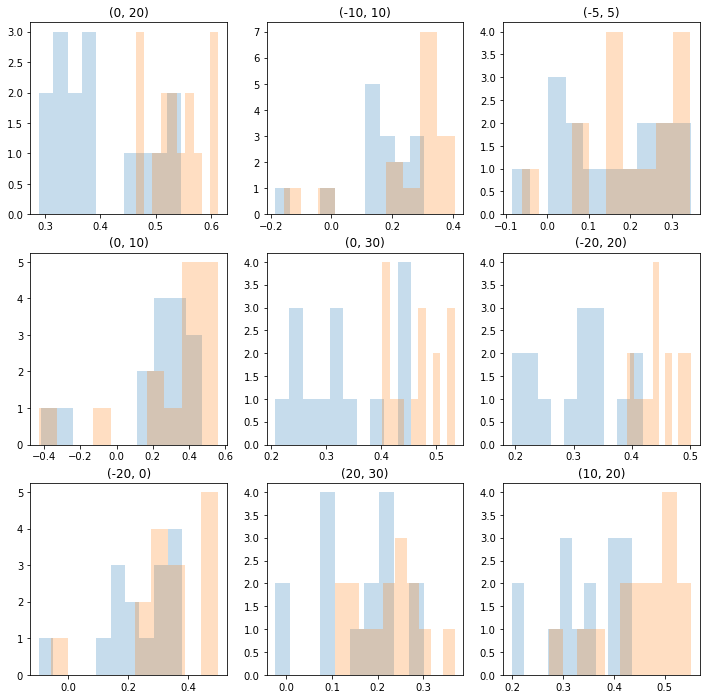

In [79]:
# Plot histogram of r2 values across the different windows
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
dim_idx = 2
for i in range(len(windows)):
    a = ax[np.unravel_index(i, (3,3))]
    a.set_title(windows[i])

    a.hist(wr2[:, :, dim_idx, i, 0, 4].ravel(), alpha=0.25)
    a.hist(wr2[:, :, dim_idx, i, 1, 4].ravel(), alpha=0.25)


In [57]:
dat.keys()

dict_keys(['spike_rates', 'behavior', 'target', 'time', 'vel', 'target_pairs', 'transition_times', 'straight_dev', 'target_pair_error', 'transition_orientation'])

In [86]:
np.where(vel_ > np.max(vel_)/2)

(array([ 7,  8,  9, 10, 13]),)

In [126]:
# Again, but now organize by locking to various features of the velocity. 

# Try to identify stereotyped reaches (only one peak in the velocity)

data_files = np.unique(sabes_df1['data_file'].values)
folds = np.arange(5)
#dimvals = np.unique(sabes_df1['dim'].values)[0:21]
dimvals = np.array([2, 6, 10, 15, 20])

lag = 4
decoding_window = 5

vwr2 = np.zeros((len(data_files), folds.size, dimvals.size, 6, 2, 6))


for i, data_file in enumerate(data_files):
    
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

    vel = np.diff(dat['behavior'], axis=0)
    transition_times = dat['transition_times']

    npeaks = []
    pks = []
    pkdata = []

    for t0, t1 in transition_times:
        vel_ = np.linalg.norm(vel[t0:t1, :], axis=1)
        pks_, pkdata = scipy.signal.find_peaks(vel_, prominence=2)
        npeaks.append(len(pks_))
        pks.append(pks_)

    single_peak_reaches = np.where(np.array(npeaks) == 1)[0]
    pks = [pks[idx] for idx in single_peak_reaches]
    transition_times = np.array(transition_times)[single_peak_reaches]

    # Take a look at (1) Beginning to half max, (2) half max to half max (3) half max to end (4) peak to end
    pw = []
    for k, (t0, t1) in enumerate(transition_times):
        vel_ = np.linalg.norm(vel[t0:t1, :], axis=1)
        pstart = np.where(vel_ > np.max(vel_)/2)[0][0]
        pend = np.where(vel_ > np.max(vel_)/2)[0][-1]
        pw.append((pstart, np.argmax(vel_), pend))

    windows = []
    valid_transition_times = []
    for k1 in range(6):
        windows.append([])    
        valid_transition_times.append([])


    # Modify to ensure that the window size is at least as long as the decoding window
    for k2 in range(len(pw)):

        start = 0
        end = pw[k2][0]
        if end - start > decoding_window + 1: 
            windows[0].append((start, end))
            valid_transition_times[0].append(transition_times[k2])

        start = pw[k2][0]
        end = pw[k2][2]
        if end - start > decoding_window + 1: 
            windows[1].append((start, end))
            valid_transition_times[1].append(transition_times[k2])

        start = pw[k2][0]
        end = transition_times[k2][1] - transition_times[k2][0]
        if end - start > decoding_window + 1: 
            windows[2].append((start, end))
            valid_transition_times[2].append(transition_times[k2])

        start = pw[k2][1]
        end = transition_times[k2][1] - transition_times[k2][0]
        if end - start > decoding_window + 1: 
            windows[3].append((start, end))
            valid_transition_times[3].append(transition_times[k2])


        start = pw[k2][2]
        end = transition_times[k2][1] - transition_times[k2][0]
        if end - start > decoding_window + 1: 
            windows[4].append((start, end))
            valid_transition_times[4].append(transition_times[k2])

        start = -5
        end = pw[k2][0]
        if end - start > decoding_window + 1: 
            windows[5].append((start, end))
            valid_transition_times[5].append(transition_times[k2])

    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    for f, fold in enumerate(folds):
        for d, dimval in tqdm(enumerate(dimvals)):
            df1 = apply_df_filters(sabes_df1, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dimval)
            df2 = apply_df_filters(sabes_df2, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval,
                                    dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

            # Apply projection
            xpca = X @ df1.iloc[0]['coef'][:, 0:dimval]
            xfcca = X @ df2.iloc[0]['coef']

            for j, window in enumerate(windows):
                if len(window) > 10:
                    r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _, _, _, _ = lr_decode_windowed(xpca, Z, lag, window, valid_transition_times[j],
                                                                df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=decoding_window) 
                    vwr2[i, f, d, j, 0, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
                    r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _, _, _, _ = lr_decode_windowed(xfcca, Z, lag, window, valid_transition_times[j],
                                                                df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=decoding_window)
                    vwr2[i, f, d, j, 1, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
                else:
                    vwr2[i, f, d, j, 0, :] = (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
                    vwr2[i, f, d, j, 1, :] = (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)




Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.76s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:33,  6.76s/it]
5it [00:36,  7.24s/it]
5it [00:34,  6.96s/it]
5it [00:34,  6.90s/it]
0it [00:00, ?it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/dyn/

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.09s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [01:14, 14.88s/it]
5it [01:14, 14.97s/it]
5it [01:14, 14.96s/it]
0it [00:11, ?it/s]


KeyboardInterrupt: 

In [121]:
pks

[array([12]),
 array([5]),
 array([13]),
 array([8]),
 array([16]),
 array([16]),
 array([9]),
 array([9]),
 array([15]),
 array([9]),
 array([14]),
 array([10]),
 array([12]),
 array([10]),
 array([10]),
 array([13]),
 array([10]),
 array([11]),
 array([8]),
 array([11]),
 array([12]),
 array([10]),
 array([14]),
 array([14]),
 array([16]),
 array([8]),
 array([10]),
 array([9]),
 array([8]),
 array([11]),
 array([11]),
 array([11]),
 array([14]),
 array([10]),
 array([8]),
 array([11]),
 array([27]),
 array([10]),
 array([11]),
 array([9]),
 array([12]),
 array([12]),
 array([8]),
 array([9]),
 array([15]),
 array([13]),
 array([13]),
 array([17]),
 array([11]),
 array([9]),
 array([20]),
 array([11]),
 array([19]),
 array([6]),
 array([14]),
 array([13]),
 array([13]),
 array([10]),
 array([16]),
 array([7]),
 array([80]),
 array([15]),
 array([8]),
 array([7]),
 array([11]),
 array([15]),
 array([10]),
 array([11]),
 array([11]),
 array([15]),
 array([9]),
 array([14]),
 array([11]

In [ ]:
# Load an dcosolidate the results. Plot the delta r^2 across windows.

In [127]:
atype0 = glob.glob('/home/akumar/nse/neural_control/analysis_scripts/atype0*.npz')

In [129]:
dat = np.load(atype0[0])

In [131]:
list(dat.keys())

['r2', 'mse']

In [132]:
dat['r2'].shape

(5, 9, 2, 6)

In [140]:
f.split('fold')[1].split('.npz')[0]

'2'

In [142]:
r2l = [[] for f in range(5)]
msel = [[] for f in range(5)]
for f in atype0:
    dat = np.load(f, allow_pickle=True)
    fidx = int(f.split('fold')[1].split('.npz')[0])
    r2l[fidx].append(dat['r2'][np.newaxis])
    msel[fidx].append(dat['mse'][np.newaxis])

In [162]:
r2 = np.transpose(np.array([np.concatenate(r) for r in r2l]), (1, 0, 2, 3, 4, 5))

In [ ]:
# Plot the delta r^2 across window

In [164]:
r2.shape

(26, 5, 5, 9, 2, 6)

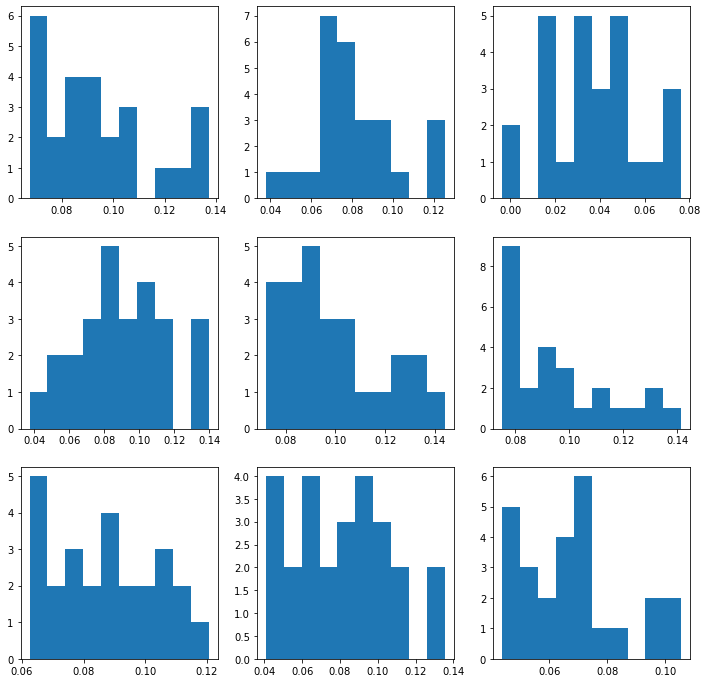

In [169]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
didx = 2

for i in range(r2.shape[-3]):
    a = ax[np.unravel_index(i, (3, 3))]
    a.hist(np.mean(r2[:, :, didx, i, 1, 4] - r2[:, :, didx, i, 0, 4], axis=1).ravel())

In [170]:
# Substantial across the entire reach? You can run statistical tests

In [176]:
len(msel[0])

26

In [174]:
msel[0][0].shape

(1, 5, 9, 2, 2)

In [182]:
np.array(msel[0][0][0, 0, 0, 0, 0]).shape

(357, 6)

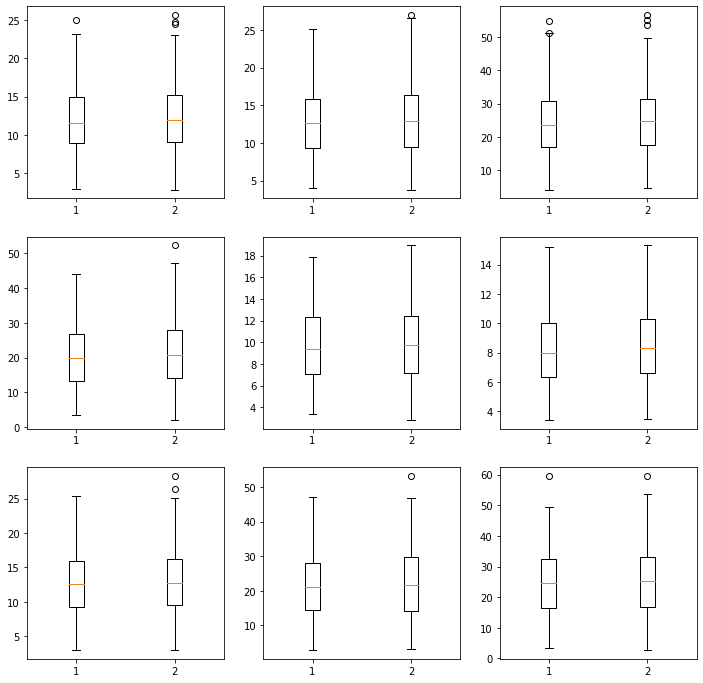

In [190]:
# Fix the fold, data file, dimension and plot boxplots of the MSE
fold_idx = 2
didix = 10
dimidx = 3
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(r2.shape[-3]):
    a = ax[np.unravel_index(i, (3, 3))]
    a.boxplot([np.linalg.norm(np.array(msel[fold_idx][didx][0, dimidx, i, 0, 0])[:, 0:2], axis=-1),
              np.linalg.norm(np.array(msel[fold_idx][didx][0, dimidx, i, 1, 0])[:, 0:2], axis=-1)])

In [192]:
# Let's collect indices corresponding to
# single velocity peak reaches (already done)
# Straightest reaches 
# Straightest reaches
# Reach distance
# Reach orientation
# Curved reaches
# Reach time
# Reach error
# Error threhold

# The corresponding analysis has to be re-run isolating thos ereaches only

In [59]:
from tqdm import tqdm
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
from sklearn.decomposition import PCA

In [61]:
# Fit FCCA and PCA on d = 2, 6, 10, 15 without cross validation for use in decoding v t
dimvals = [2, 6, 10, 15]
rl = []
for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    pcamodel = PCA().fit(X)

    for j, dim in enumerate(dimvals):
        lqgmodel = LQGCA(T=3, loss_type='trace', n_init=5)
        lqgmodel.fit(X, d=dim)

        result = {}
        result['data_file'] = data_file
        result['dim'] = dim
        result['lqgcoef'] = lqgmodel.coef_
        result['pcacoef'] = pcamodel.components_.T[:, 0:dim]

        rl.append(result)

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.53s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
1it [00:21, 21.29s/it]

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.09s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
2it [00:49, 25.23s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
3it [00:58, 17.69s/it]

Processing spikes


100%|██████████| 1/1 [00:27<00:00, 27.54s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
4it [01:34, 25.03s/it]

Processing spikes


100%|██████████| 1/1 [00:11<00:00, 11.82s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
5it [01:51, 22.04s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
6it [01:58, 17.05s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
7it [02:05, 13.71s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
8it [02:13, 12.05s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.30s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
9it [02:22, 10.90s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
10it [02:29,  9.76s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
11it [02:38,  9.64s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
12it [02:47,  9.29s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.51s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
13it [02:57,  9.57s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
14it [03:06,  9.32s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.29s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
15it [03:14,  9.11s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
16it [03:22,  8.82s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.94s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
17it [03:30,  8.61s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
18it [03:39,  8.65s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
19it [03:48,  8.59s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.79s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
20it [03:57,  8.96s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
21it [04:08,  9.54s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
22it [04:16,  8.98s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.61s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
23it [04:25,  9.08s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
24it [04:35,  9.20s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
25it [04:44,  9.14s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.80s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
26it [04:54,  9.53s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.00s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
27it [05:06, 10.06s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.69s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
28it [05:17, 11.33s/it]


In [62]:
with open('/home/akumar/nse/neural_control/data/sabes_dimreduc_nocv.dat', 'wb') as f:
    f.write(pickle.dumps(rl))

In [ ]:
# Note we made a modification to only consider end target error when filtering by error

In [6]:
import sys
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')
from decodingvt import gen_run

In [7]:
import sys 
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')
from decodingvt import gen_run

In [52]:
gen_run('/home/akumar/nse/neural_control/analysis_scripts/run.sh', np.arange(28), [(1., 'le'), (0.75, 'ge'), (0.5, 'ge'),(0.5, 'le'),(0.25, 'le')],
        [(0, 0, 'le'), (3, 0.5, 'le'), (3, 0.5, 'ge'), (3, 0.25, 'le'), (3, 0.75, 'ge')])

In [70]:
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvtfull/cleanedup/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-1].split('.dat')[0]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        mse = pickle.load(f)
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['mse'] = mse
    result['error_filter'] = error_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = dim
    for k, v in filter_params.items():
        result[k] = v
    rl.append(result)
df = pd.DataFrame(rl)

> /tmp/ipykernel_15077/4095064540.py(9)<module>()
      7     s = fl.split('_')[4:]
      8     pdb.set_trace()
----> 9     filter_params = {}
     10     filter_params['error_thresh'] = float(s[7])/100
     11     filter_params['error_op'] = s[-1].split('.dat')[0]

['3', 'op', 'ge', 'q', '75', 'et', '50', 'eop', 'le.dat']
['/home/akumar/nse/neural', 'control/data/decodingvtfull/cleanedup/didx2', 'dim1', 'rf', '3', 'op', 'ge', 'q', '75', 'et', '50', 'eop', 'le.dat']
['/home/akumar/nse/neural', 'control/data/decodingvtfull/cleanedup/didx2', 'dim1', 'rf', '3', 'op', 'ge', 'q', '75', 'et', '50', 'eop', 'le.dat']


BdbQuit: 

In [10]:
with open('/mnt/sdb1/nc_data/dvt_df.dat', 'rb') as f:
    rl = pickle.load(f)
dvt_df = pd.DataFrame(rl)

with open('/mnt/sdb1/nc_data/sabes_dimreduc_nocv.dat', 'rb') as f:
    rl = pickle.load(f)
sabes_df = pd.DataFrame(rl)

In [11]:
# Plots: Reproduce with denser windows and proper paired comparisons. First, produce with no regard for the number of reaches contained in each window

In [21]:
df_.iloc[0]['r2'].shape

(15, 2, 6)

In [ ]:
# data file used to plot reaches

In [23]:
data_file = np.unique(sabes_df['data_file'].values)[2]

In [25]:
dat = load_sabes('/mnt/sdb1/nc_data/sabes/%s' % data_file)
dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.49s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


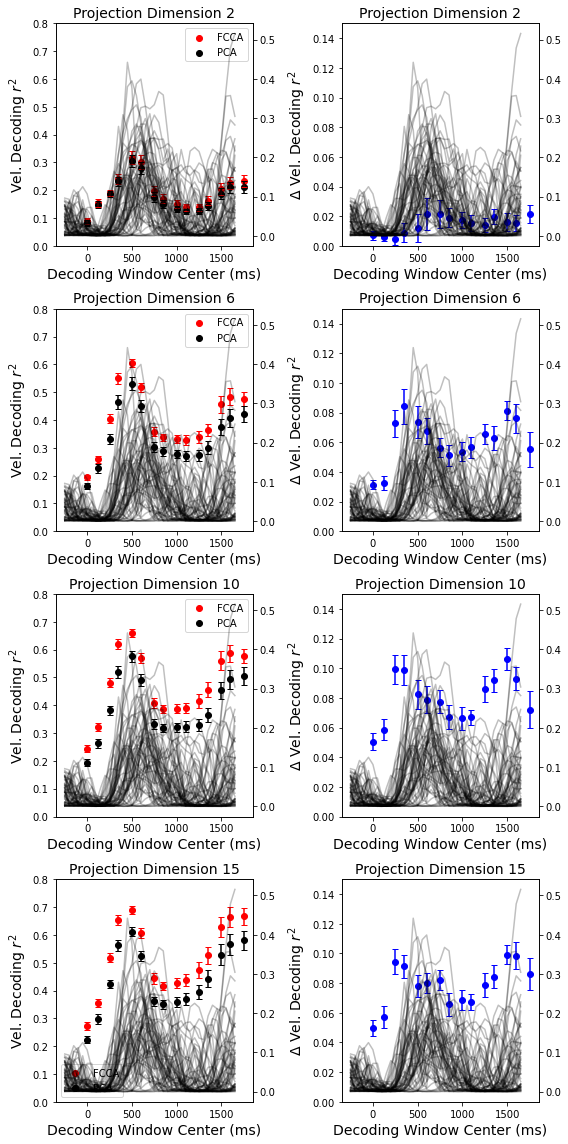

In [28]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
windows = dvt_df.iloc[0]['window']
window_centers = np.mean(windows, axis=1)

true_dimvals = np.array([2, 6, 10, 15])

for i, dim in enumerate(dimvals):

    df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=dim)

    r2f = []
    r2p = []

    for j in range(df_.shape[0]):
        r2f.append(df_.iloc[j]['r2'][:, 1, 1])
        r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

    r2f = np.array(r2f).T
    r2p = np.array(r2p).T

    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r')
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k')

    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2f], color='r')
    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2p], color='k')

    ax[i, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                     [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b')
    ax[i, 1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='b')

    ax[i, 0].set_ylim([0, 0.8])
    ax[i, 1].set_ylim([0, 0.15])
    ax[i, 0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)

    ax[i, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


    ax[i,  0].set_title('Projection Dimension %d' % true_dimvals[i], fontsize=14)
    ax[i,  1].set_title('Projection Dimension %d' % true_dimvals[i], fontsize=14)

    ax[i, 0].legend(['FCCA', 'PCA'])
    # ax[i, 1].plot(window_centers, r2f)
    # ax[i, 1].plot(window_centers, r2p)

    a = ax[i, 0].twinx()
    a2 = ax[i, 1].twinx()
    
    for tt in dat['transition_times'][::5]:
        vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 35], axis=0), axis=1)/(1e3 * 0.05)
        a.plot(50 * np.arange(-5, 34), vel, color='k', alpha=0.25)
        a2.plot(50 * np.arange(-5, 34), vel, color='k', alpha=0.25)
        
fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/overall.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Is the effect regarding the late rise in r^2 real? We should have filtered for reaches accordingly

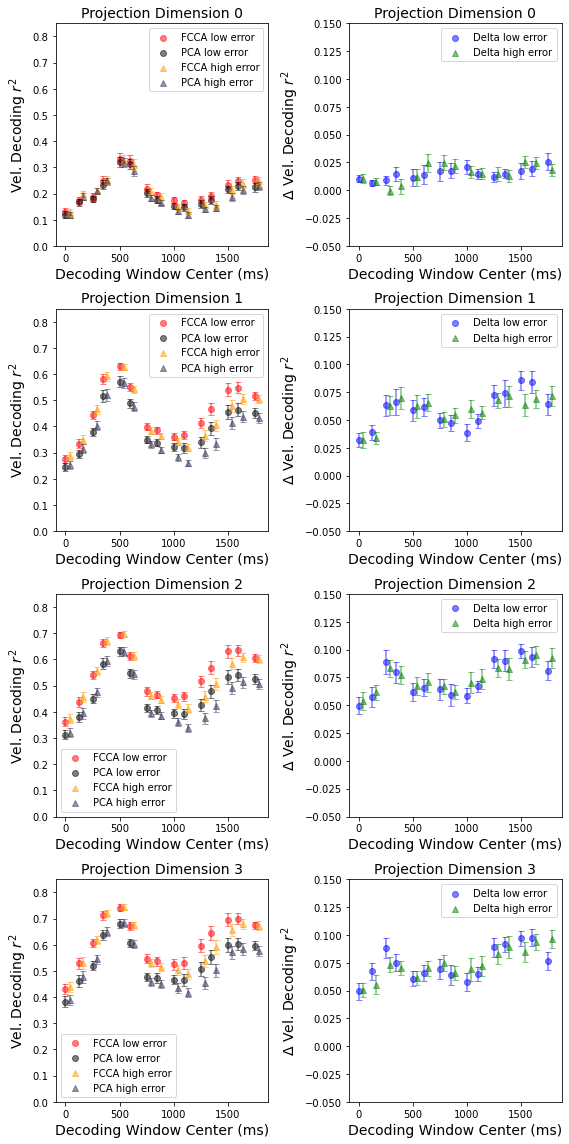

In [36]:
# Low error vs high error reaches, end target error only

fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i in range(4):
    df_ = apply_df_filters(dvt_df, error_thresh=0.25, error_op='le', filter_type=0, q=0, op='le', dim=i)

    r2f = []
    r2p = []

    for j in range(df_.shape[0]):
        r2f.append(df_.iloc[j]['r2'][:, 1, 1])
        r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

    r2f = np.array(r2f).T
    r2p = np.array(r2p).T

    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', alpha=0.5)
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', alpha=0.5)

    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2f], color='r', alpha=0.5)
    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2p], color='k', alpha=0.5)


    ax[i, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                     [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', alpha=0.5)
    ax[i, 1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='b', alpha=0.5)

    df_ = apply_df_filters(dvt_df, error_thresh=0.75, error_op='ge', filter_type=0, q=0, op='le', dim=i)
    r2f = []
    r2p = []

    for j in range(df_.shape[0]):
        r2f.append(df_.iloc[j]['r2'][:, 1, 1])
        r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

    r2f = np.array(r2f).T
    r2p = np.array(r2p).T

    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='#ff9a03', alpha=0.5)
    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='#373157', alpha=0.5)

    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], color='#ff9a03', marker='^', alpha=0.5)
    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], color='#373157', marker='^', alpha=0.5)

    ax[i, 1].errorbar(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                      [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='g', alpha=0.5)
    ax[i, 1].scatter(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='g', alpha=0.5, marker='^')

    ax[i, 0].set_ylim([0, 0.85])
    ax[i, 1].set_ylim([-0.05, 0.15])
    ax[i, 0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
    ax[i, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

    ax[i,  0].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)
    ax[i,  1].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)

    ax[i, 0].legend(['FCCA low error', 'PCA low error', 'FCCA high error', 'PCA high error'])
    ax[i, 1].legend(['Delta low error', 'Delta high error'])


    # ax[i, 1].plot(window_centers, r2f)
    # ax[i, 1].plot(window_centers, r2p)
fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/highvlowerror.pdf', bbox_inches='tight', pad_inches=0)

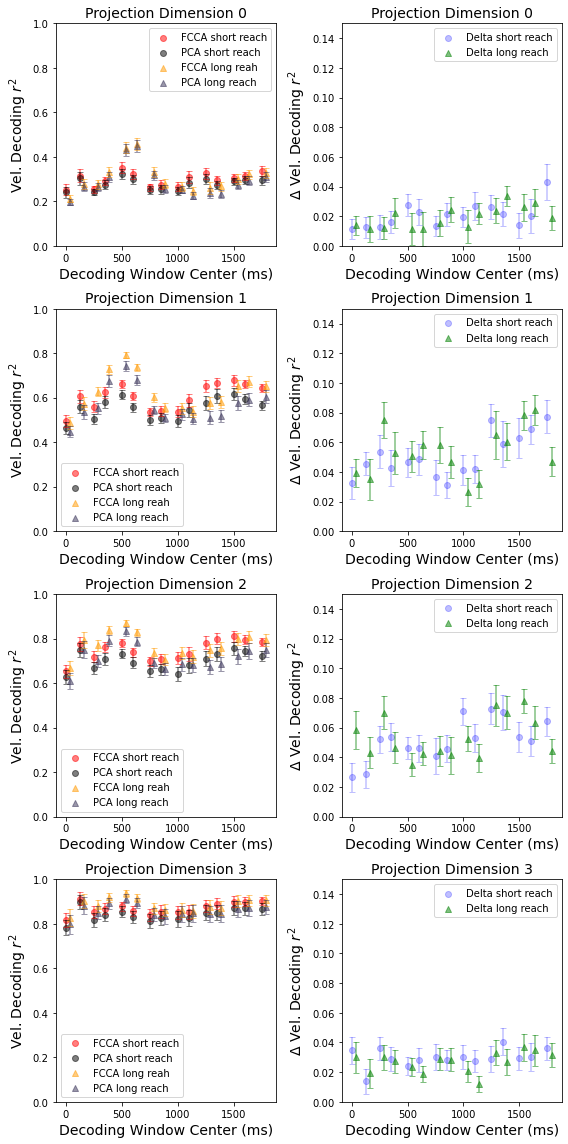

In [38]:
# Next, long vs. short reaches:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i in range(4):
    df_ = apply_df_filters(dvt_df, error_thresh=0.25, error_op='le', filter_type=3, q=0.25, op='le', dim=i)

    r2f = []
    r2p = []

    for j in range(df_.shape[0]):
        r2f.append(df_.iloc[j]['r2'][:, 1, 1])
        r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

    r2f = np.array(r2f).T
    r2p = np.array(r2p).T
    
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', alpha=0.5)
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', alpha=0.5)

    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2f], color='r', alpha=0.5)
    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2p], color='k', alpha=0.5)


    ax[i, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                      [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', alpha=0.25)
    ax[i, 1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='b', alpha=0.25)

    df_ = apply_df_filters(dvt_df, error_thresh=0.25, error_op='le', filter_type=3, q=0.75, op='ge', dim=i)

    r2f = []
    r2p = []

    for j in range(df_.shape[0]):
        r2f.append(df_.iloc[j]['r2'][:, 1, 1])
        r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

    r2f = np.array(r2f).T
    r2p = np.array(r2p).T

    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='#ff9a03', alpha=0.5)
    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='#373157', alpha=0.5)

    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], color='#ff9a03', marker='^', alpha=0.5)
    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], color='#373157', marker='^', alpha=0.5)


    ax[i, 1].errorbar(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                     [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='g', alpha=0.5)
    ax[i, 1].scatter(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='g', alpha=0.5, marker='^')

    ax[i, 0].set_ylim([0, 1])
    ax[i, 1].set_ylim([0., 0.15])
    ax[i, 0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
    ax[i, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

    ax[i,  0].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)
    ax[i,  1].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)

    ax[i, 0].legend(['FCCA short reach', 'PCA short reach', 'FCCA long reah', 'PCA long reach'])
    ax[i, 1].legend(['Delta short reach', 'Delta long reach'])

    # ax[i, 1].plot(window_centers, r2f)
    # ax[i, 1].plot(window_centers, r2p)
fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/shortvlong.pdf', bbox_inches='tight', pad_inches=0)

In [53]:
# Why did certain data files fail to compute? Answer: We were including reaches at the end of the session
df_ = apply_df_filters(dvt_df, error_thresh=1., error_op='le', filter_type=0, q=0., op='le', dim=3)
np.sort(df_['didx'].values)

array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11, 12, 13, 14, 18, 19, 23, 24,
       25, 26, 27])

In [ ]:
# Applying the target error to both the beginning and end seems to make a big difference. Re-run with target error assessed on both

In [42]:
with open('/home/akumar/nse/neural_control/data/dvt_df2.dat', 'rb') as f:
    rl = pickle.load(f)
dvt_df = pd.DataFrame(rl)

with open('/home/akumar/nse/neural_control/data/sabes_dimreduc_nocv.dat', 'rb') as f:
    rl = pickle.load(f)
sabes_df = pd.DataFrame(rl)

In [43]:
data_idx = 0
data_file = np.unique(sabes_df['data_file'].values)[data_idx]

In [44]:
dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.77s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


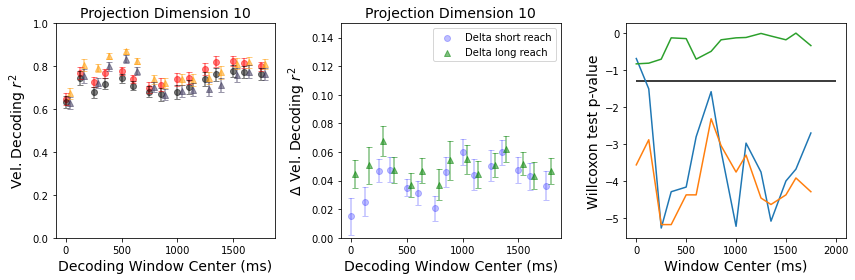

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
windows = dvt_df.iloc[0]['window']
window_centers = np.mean(windows, axis=1)

true_dimvals = np.array([2, 6, 10, 15])

df_ = apply_df_filters(dvt_df, error_thresh=0.25, error_op='le', filter_type=3, q=0.25, op='le', dim=2)

r2fs = []
r2ps = []

for j in range(df_.shape[0]):
    r2fs.append(df_.iloc[j]['r2'][:, 1, 1])
    r2ps.append(df_.iloc[j]['r2'][:, 0, 1])        

r2fs = np.array(r2fs).T
r2ps = np.array(r2ps).T

ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2fs], [np.std(r)/np.sqrt(r.size) for r in r2fs], linestyle='', capsize=3, color='r', alpha=0.5)
ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2ps], [np.std(r)/np.sqrt(r.size) for r in r2ps], linestyle='', capsize=3, color='k', alpha=0.5)

ax[0].scatter(50 * window_centers, [np.mean(r) for r in r2fs], color='r', alpha=0.5)
ax[0].scatter(50 * window_centers, [np.mean(r) for r in r2ps], color='k', alpha=0.5)


ax[1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2fs, r2ps)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2fs, r2ps)], linestyle='', capsize=3, color='b', alpha=0.25)
ax[1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2fs, r2ps)], color='b', alpha=0.25)

df_ = apply_df_filters(dvt_df, error_thresh=0.25, error_op='le', filter_type=3, q=0.75, op='ge', dim=2)

r2fl = []
r2pl = []

for j in range(df_.shape[0]):
    r2fl.append(df_.iloc[j]['r2'][:, 1, 1])
    r2pl.append(df_.iloc[j]['r2'][:, 0, 1])        

r2fl = np.array(r2fl).T
r2pl = np.array(r2pl).T

ax[0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2fl], [np.std(r)/np.sqrt(r.size) for r in r2fl], linestyle='', capsize=3, color='#ff9a03', alpha=0.5)
ax[0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2pl], [np.std(r)/np.sqrt(r.size) for r in r2pl], linestyle='', capsize=3, color='#373157', alpha=0.5)

ax[0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2fl], color='#ff9a03', marker='^', alpha=0.5)
ax[0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2pl], color='#373157', marker='^', alpha=0.5)


ax[1].errorbar(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2fl, r2pl)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2fl, r2pl)], linestyle='', capsize=3, color='g', alpha=0.5)
ax[1].scatter(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2fl, r2pl)], color='g', alpha=0.5, marker='^')

p1 = np.zeros(window_centers.size)
p2 = np.zeros(window_centers.size)
p3 = np.zeros(window_centers.size)
for k in range(window_centers.size):
    stat, p_ = scipy.stats.wilcoxon(r2fs[k], r2ps[k])
    p1[k] = p_

    stat, p_ = scipy.stats.wilcoxon(r2fl[k], r2pl[k])
    p2[k] = p_
    stat, p_ = scipy.stats.wilcoxon(r2fl[k] - r2pl[k], r2fs[k] - r2ps[k])
    p3[k] = p_

ax[2].plot(50 * window_centers, np.log10(p1))
ax[2].plot(50 * window_centers, np.log10(p2))
ax[2].plot(50 * window_centers, np.log10(p3))
ax[2].hlines(np.log10(0.05), 0, 2000, 'k')
ax[2].set_ylabel('Willcoxon test p-value', fontsize=14)
ax[2].set_xlabel('Window Center (ms)', fontsize=14)
#ax[1, 2].legend(['FCCA vs. PCA short', 'FCCA vs. PCA long', 'Delta short vs. long'])

ax[0].set_ylim([0, 1])
ax[1].set_ylim([0., 0.15])
ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
ax[1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

ax[0].set_title('Projection Dimension 10', fontsize=14)
ax[1].set_title('Projection Dimension 10', fontsize=14)

ax[1].legend(['FCCA short reach', 'PCA short reach', 'FCCA long reach', 'PCA long reach'])
ax[1].legend(['Delta short reach', 'Delta long reach'])

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/length_significance.pdf', bbox_inches='tight', pad_inches=0)

In [164]:
# Define widnows with respect to the end of reaches 
gen_run('/home/akumar/nse/neural_control/analysis_scripts/run.sh', np.arange(28), [(1., 'le')], [(0, 0, 'le')])

In [48]:
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvt2/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        idxs = pickle.load(f)
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['idxs'] = idxs
    result['error_filter'] = error_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = dim
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
        rl.append(result)
dvt_df = pd.DataFrame(rl)

In [79]:
# We accidently overwrote the raw files above, so we save the df here:
# with open('/home/akumar/nse/neural_control/data/dvt_df3.dat', 'wb') as f:
#     f.write(pickle.dumps(dvt_df))
with open('/home/akumar/nse/neural_control/data/dvt_df3.dat', 'rb') as f:
    dvt_df = pickle.load(f)

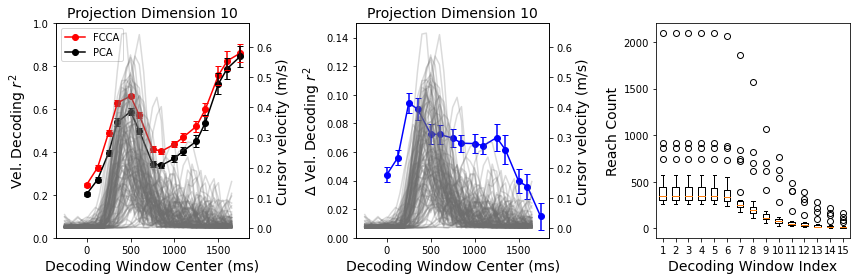

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
windows = dvt_df.iloc[0]['window']
window_centers = np.mean(windows, axis=1)

true_dimvals = np.array([2, 6, 10, 15])
df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=2)
a = ax[0].twinx()
a2 = ax[1].twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=data_idx)
valid_idxs = d.iloc[0]['idxs']

# Intersection
common_idxs = set(valid_idxs[0])
for k in range(1, len(valid_idxs)):
    common_idxs = common_idxs.intersection(set(valid_idxs[k]))

for tt in np.array(dat['transition_times'])[list(common_idxs)]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 35], axis=0), axis=1)/(1e3 * 0.05)
    a.plot(50 * np.arange(-5, 34), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-5, 34), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a2.set_ylabel('Cursor velocity (m/s)', fontsize=14)


nreaches = np.zeros((df_.shape[0], window_centers.size))
for j in range(df_.shape[0]):
    # Number of valid reaches as a function of window center
    nreaches[j] = np.array([len(df_.iloc[j]['idxs'][k]) for k in range(window_centers.size)])    

# Number of valid reaches as a function of window center
ax[2].boxplot(nreaches)
ax[2].set_ylabel('Reach Count', fontsize=14)
ax[2].set_xlabel('Decoding Window Index', fontsize=14)

r2f = []
r2p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 1])
    r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

r2f = np.array(r2f).T
r2p = np.array(r2p).T

ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', zorder=5)
ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', zorder=5)

ax[0].plot(50 * window_centers, [np.mean(r) for r in r2f], '-o', color='r', zorder=4)
ax[0].plot(50 * window_centers, [np.mean(r) for r in r2p], '-o', color='k', zorder=4)

ax[1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', zorder=5)
ax[1].plot(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], '-o', color='b', zorder=4)

ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 0.15])
ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
ax[1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


ax[0].set_title('Projection Dimension 10', fontsize=14)
ax[1].set_title('Projection Dimension 10', fontsize=14)

ax[0].legend(['FCCA', 'PCA'])
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/reach_counts.pdf', bbox_inches='tight', pad_inches=0)

In [81]:
# Seems like one should restrict to the most restrictive reach condition and truncate at window 8
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvt2/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['window_filter'] = window_filter
    result['didx'] = didx
    result['dim'] = dim
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    rl.append(result)
dvt_df = pd.DataFrame(rl)

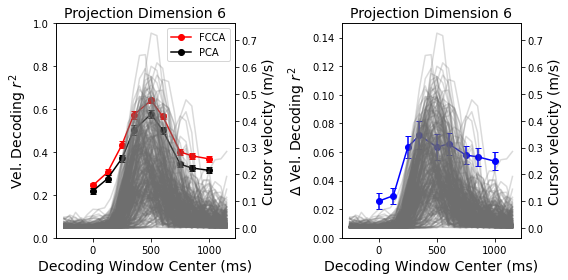

In [82]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

windows = dvt_df.iloc[0]['window'][0:9]
window_centers = np.mean(windows, axis=1)

true_dimvals = np.array([2, 6, 10, 15])
df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=1)
a = ax[0].twinx()
a2 = ax[1].twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=data_idx)
error_filter = d.iloc[0]['error_filter']
reach_filter = d.iloc[0]['reach_filter']
window_filter = d.iloc[0]['window_filter']

# Intersection
transition_times = np.array(dat['transition_times'])[error_filter][reach_filter][window_filter]

for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 25], axis=0), axis=1)/(1e3 * 0.05)
    a.plot(50 * np.arange(-5, 24), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-5, 24), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a2.set_ylabel('Cursor velocity (m/s)', fontsize=14)


r2f = []
r2p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 1])
    r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

r2f = np.array(r2f).T
r2p = np.array(r2p).T

ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', zorder=5)
ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', zorder=5)

ax[0].plot(50 * window_centers, [np.mean(r) for r in r2f], '-o', color='r', zorder=4)
ax[0].plot(50 * window_centers, [np.mean(r) for r in r2p], '-o', color='k', zorder=4)

ax[1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', zorder=5)
ax[1].plot(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], '-o', color='b', zorder=4)

ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 0.15])
ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
ax[1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


ax[0].set_title('Projection Dimension 6', fontsize=14)
ax[1].set_title('Projection Dimension 6', fontsize=14)

ax[0].legend(['FCCA', 'PCA'])

# In the last figure, plot the reaches
z = []

# reaches1 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] >= high_error)[:, 0]]
# reaches2 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] <= low_error)[:, 0]]
for i in range(transition_times.shape[0]):
    z.append(dat['behavior'][transition_times[i, 0]:transition_times[i, 1]])
    
# for i in range(0, transition_times.shape[0], 2):
#     z_ = z[i] - z[i][0]
#     ax[2].plot(z_[:, 0], z_[:, 1], color='k', alpha=0.25)
#     ax[2].set_xlim([-180, 180])
#     ax[2].set_ylim([-100, 100])    

#     ax[2].set_xlabel('X (mm)', fontsize=12)
#     ax[2].set_ylabel('Y (mm)', fontsize=12)
#     ax[2].set_title('Example Reaches', fontsize=14)
#     ax[2].set_aspect('equal')

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/final_old.pdf', bbox_inches='tight', pad_inches=0)

In [39]:
# Measuring from the *end* of reaches
# Seems like one should restrict to the most restrictive reach condition and truncate at window 8
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvt2/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['window_filter'] = window_filter
    result['didx'] = didx
    result['dim'] = dim
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    rl.append(result)
dvt_df = pd.DataFrame(rl)

In [212]:
dvt_df.shape

(224, 13)

In [213]:
dvt_df = apply_df_filters(dvt_df, measure_from_end=True)

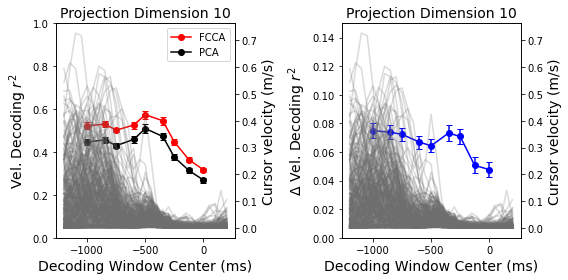

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
windows = dvt_df.iloc[0]['window'][0:9]
window_centers = -1 * np.mean(windows, axis=1)

true_dimvals = np.array([2, 6, 10, 15])
df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=2)
a = ax[0].twinx()
a2 = ax[1].twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=data_idx)
error_filter = d.iloc[0]['error_filter']
reach_filter = d.iloc[0]['reach_filter']
window_filter = d.iloc[0]['window_filter']

# Intersection
transition_times = np.array(dat['transition_times'])[error_filter][reach_filter][window_filter]

for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[1] - 25:tt[1] + 5], axis=0), axis=1)/(1e3 * 0.05)
    a.plot(50 * np.arange(-24, 5), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-24, 5)    result[k] = v
    rl.append(result)

r2f = []
r2p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 1])
    r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

r2f = np.array(r2f).T
r2p = np.array(r2p).T

ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', zorder=5)
ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', zorder=5)

ax[0].plot(50 * window_centers, [np.mean(r) for r in r2f], '-o', color='r', zorder=4)
ax[0].plot(50 * window_centers, [np.mean(r) for r in r2p], '-o', color='k', zorder=4)

ax[1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', zorder=5)
ax[1].plot(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], '-o', color='b', zorder=4)

ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 0.15])
ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
ax[1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


ax[0].set_title('Projection Dimension 10', fontsize=14)
ax[1].set_title('Projection Dimension 10', fontsize=14)

ax[0].legend(['FCCA', 'PCA'])

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/fromend.pdf', bbox_inches='tight', pad_inches=0)

### Run with revised FCCA 

In [6]:
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')

In [7]:
from decodingvt import gen_run

In [8]:
# Define widnows with respect to the end of reaches 
gen_run('/home/akumar/nse/neural_control/analysis_scripts/run.sh', np.arange(28), [(1., 'le')], [(0, 0, 'le')])

In [16]:
with open('/home/akumar/nse/neural_control/data/indy_dimreduc_nocv.dat', 'rb') as f:
    rl = pickle.load(f)
sabes_df = pd.DataFrame(rl)

data_idx = 0
data_file = np.unique(sabes_df['data_file'].values)[data_idx]

dat = load_sabes(data_file)
dat = reach_segment_sabes(dat, start_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvt3/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = dim
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
        rl.append(result)
dvt_df = pd.DataFrame(rl)

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.53s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [17]:
data_file

'/mnt/Secondary/data/sabes/indy_20160426_01.mat'

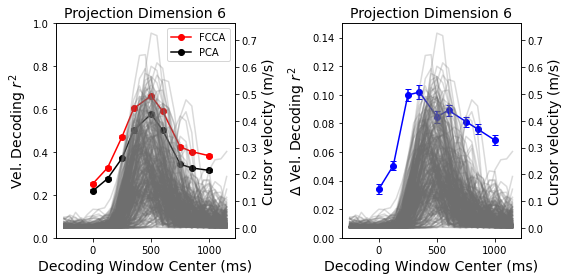

In [13]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

windows = dvt_df.iloc[0]['window'][0:9]
window_centers = np.mean(windows, axis=1)

true_dimvals = np.array([2, 6, 10, 15])
df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=1)
a = ax[0].twinx()
a2 = ax[1].twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=data_idx)
error_filter = d.iloc[0]['error_filter']
reach_filter = d.iloc[0]['reach_filter']
window_filter = d.iloc[0]['window_filter']

# Intersection
transition_times = np.array(dat['transition_times'])[error_filter][reach_filter][window_filter]

for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 25], axis=0), axis=1)/(1e3 * 0.05)
    a.plot(50 * np.arange(-5, 24), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)
    a2.plot(50 * np.arange(-5, 24), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a2.set_ylabel('Cursor velocity (m/s)', fontsize=14)


r2f = []
r2p = []

for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 1])
    r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

r2f = np.array(r2f).T
r2p = np.array(r2p).T

ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', zorder=5)
ax[0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', zorder=5)

ax[0].plot(50 * window_centers, [np.mean(r) for r in r2f], '-o', color='r', zorder=4)
ax[0].plot(50 * window_centers, [np.mean(r) for r in r2p], '-o', color='k', zorder=4)

ax[1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', zorder=5)
ax[1].plot(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], '-o', color='b', zorder=4)

ax[0].set_ylim([0, 1.0])
ax[1].set_ylim([0, 0.15])
ax[0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
ax[0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
ax[1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


ax[0].set_title('Projection Dimension 6', fontsize=14)
ax[1].set_title('Projection Dimension 6', fontsize=14)

ax[0].legend(['FCCA', 'PCA'])

# In the last figure, plot the reaches
z = []

# reaches1 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] >= high_error)[:, 0]]
# reaches2 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] <= low_error)[:, 0]]
for i in range(transition_times.shape[0]):
    z.append(dat['behavior'][transition_times[i, 0]:transition_times[i, 1]])
    
# for i in range(0, transition_times.shape[0], 3):
#     z_ = z[i] - z[i][0]
#     ax[2].plot(z_[:, 0], z_[:, 1], color='k', alpha=0.25)
#     ax[2].set_xlim([-180, 180])
#     ax[2].set_ylim([-100, 100])    
#     ax[2].set_aspect('equal')
#     ax[2].set_xlabel('X (mm)', fontsize=12)
#     ax[2].set_ylabel('Y (mm)', fontsize=12)
#     ax[2].set_title('Example Reaches', fontsize=14)

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/final.pdf', bbox_inches='tight', pad_inches=0)

### Marginal FCCA

In [8]:
# Define widnows with respect to the end of reaches 
gen_run('/home/akumar/nse/neural_control/analysis_scripts/run.sh', np.arange(28), [(1., 'le')], [(0, 0, 'le')])

In [18]:
with open('/home/akumar/nse/neural_control/data/indy_dimreduc_marginal_nocv.dat', 'rb') as f:
    rl = pickle.load(f)

sabes_df = pd.DataFrame(rl)
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvtmarginal/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = dim
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
        rl.append(result)
dvt_df_marginal = pd.DataFrame(rl)

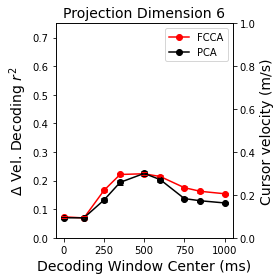

In [24]:
# Plotting paired differences between the methods and their marginal variants

fig, ax = plt.subplots(figsize=(4, 4))

windows = dvt_df.iloc[0]['window'][0:9]
window_centers = np.mean(windows, axis=1)

true_dimvals = np.array([2, 6, 10, 15])
df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=1)
df2_ = apply_df_filters(dvt_df_marginal, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=1)

a = ax.twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=data_idx)
error_filter = d.iloc[0]['error_filter']
reach_filter = d.iloc[0]['reach_filter']
window_filter = d.iloc[0]['window_filter']

# Intersection
transition_times = np.array(dat['transition_times'])[error_filter][reach_filter][window_filter]

for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 25], axis=0), axis=1)/(1e3 * 0.05)
    #a.plot(50 * np.arange(-5, 24), vel, color='#6e6e6e', alpha=0.25, zorder=0)
    a.set_ylabel('Cursor velocity (m/s)', fontsize=14)

r2f = []
r2p = []

r2fm = []
r2pm = []


for j in range(df_.shape[0]):
    r2f.append(df_.iloc[j]['r2'][:, 1, 1])
    r2p.append(df_.iloc[j]['r2'][:, 0, 1])        

for j in range(df2_.shape[0]):
    r2fm.append(df2_.iloc[j]['r2'][:, 1, 1])
    r2pm.append(df2_.iloc[j]['r2'][:, 0, 1])        
    

r2f = np.array(r2f).T
r2p = np.array(r2p).T

r2fm = np.array(r2fm).T
r2pm = np.array(r2pm).T


ax.errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2fm)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2f, r2fm)], linestyle='', capsize=3, color='r', zorder=5)
ax.errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2p, r2pm)], 
                    [np.std(r1 - r2)/np.sqrt(r1.shape[0]) for (r1, r2) in zip(r2p, r2pm)], linestyle='', capsize=3, color='k', zorder=5)

ax.plot(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2fm)], '-o', color='r', zorder=4)
ax.plot(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2p, r2pm)], '-o', color='k', zorder=4)


ax.set_ylim([0, 0.75])
ax.set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
ax.set_xlabel('Decoding Window Center (ms)', fontsize=14)
ax.set_title('Projection Dimension 6', fontsize=14)

ax.legend(['FCCA', 'PCA'])
fig.tight_layout()
# fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/final.pdf', bbox_inches='tight', pad_inches=0)

In [25]:
# Not worth including IMO